Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [66]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [67]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [68]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:

## Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                      image_size=(img_width,img_height),
                                                        seed=123)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

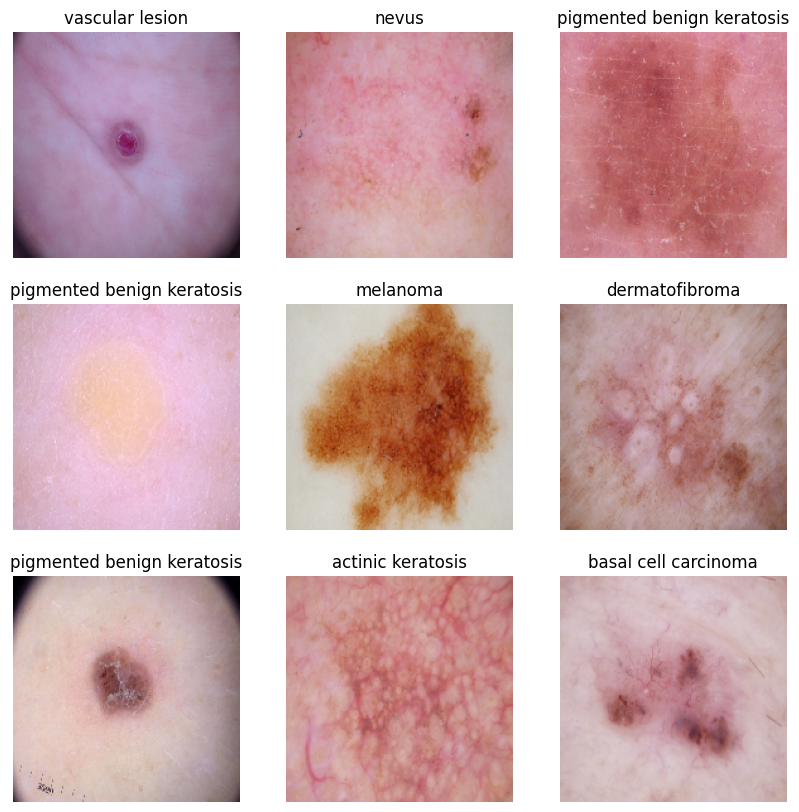

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### First CNN base model
#### 5 Conv2D layers coupled with 2*2 Maxpooling layers


In [11]:
### Your code goes here
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
from keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
#from tensorflow.python.keras import BatchNormalization

model = Sequential()

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model1 = Sequential(name="model1")


##l1
model1.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

##l2
model1.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

##l3
model1.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

##l3
model1.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

##l4
model1.add(layers.Conv2D(512, kernel_size=(3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

##l5
model1.add(layers.Flatten())


#output layer
model1.add(layers.Dense(len(class_names), activation='softmax'))



### Compile the model
#### Using Adam optimizer and sparse_categorical_crossentropy loss function

In [19]:
## selection of optimizer and loss function
from tensorflow.keras.optimizers import Adam
adam = Adam(amsgrad=True)

model1.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [20]:
# View the summary of all layers
input_shape = (None,180,180,3)
model1.build(input_shape)
model1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0    

### Train the model

In [21]:
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 29s 113ms/step - loss: 5.6279 - accuracy: 0.2785 - val_loss: 1.8022 - val_accuracy: 0.3378
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.6083 - accuracy: 0.4213 - val_loss: 1.5563 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5657 - accuracy: 0.4487 - val_loss: 1.6652 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 2s 39ms/step - loss: 1.5104 - accuracy: 0.4626 - val_loss: 1.5304 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 2s 39ms/step - loss: 1.4965 - accuracy: 0.4660 - val_loss: 1.4116 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3721 - accuracy: 0.5112 - val_loss: 1.3643 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3327 - accuracy: 0.5396 - val_loss: 1.3849 - val_accuracy: 0.5369
Epoch 8/20


### Visualizing training results

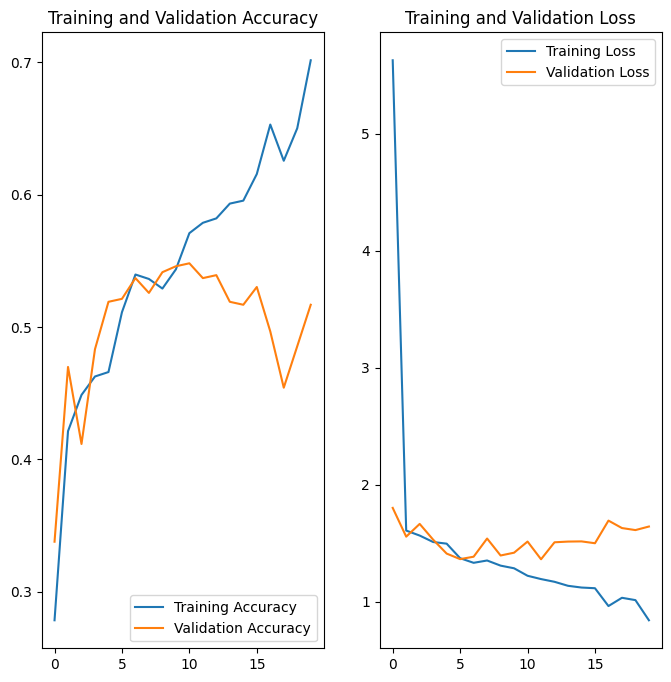

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation:-
##### Model is clearly overfitting as training accuracy(70%) is way higher than Validation accuracy(51%).

##### Let's try data augmentation and dropout to fix overfitting

In [80]:
seed=123
augmentation_pipeline = Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical", seed=seed),  # Perform random horizontal and vertical flips
    layers.RandomRotation(factor=0.2, seed=seed),  # Apply random rotation within a range of -20% to 20% of 360 degrees
    layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),  # Randomly translate images horizontally and vertically
    layers.RandomZoom(height_factor=0.1, width_factor=0.1)  # Randomly zoom in or out by 10% in height and width
])


In [28]:
rescaling_pipeline = Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1.0/255)  # Rescale pixel values to the range of 0 to 1
])


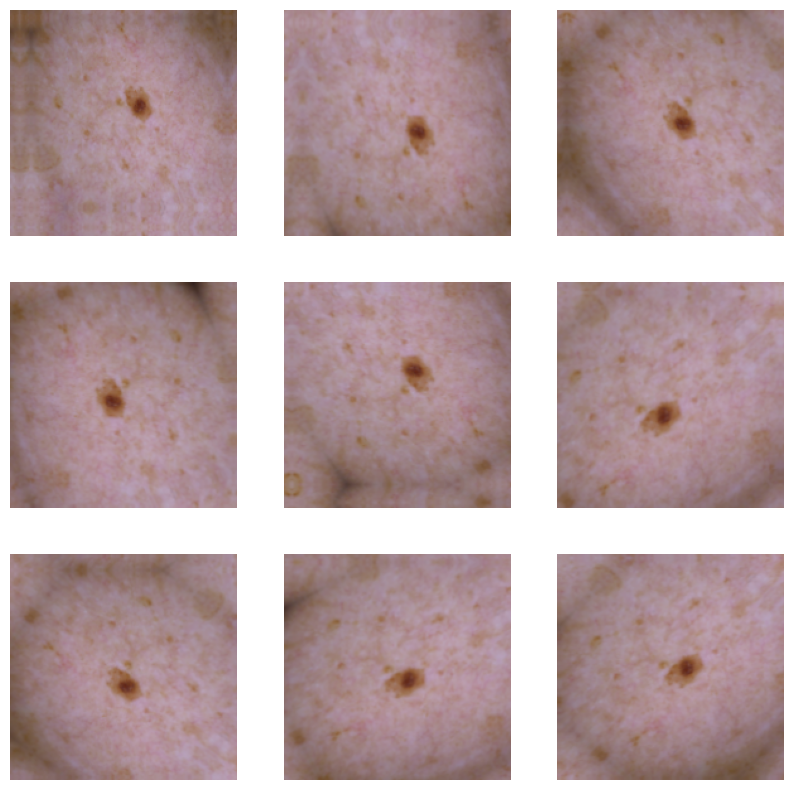

In [29]:
## Visualize augmented images
import matplotlib.pyplot as plt

figure_size = (10, 10)
num_images = 9

plt.figure(figsize=figure_size)

for image_batch, label_batch in train_ds.take(1):
    for i in range(num_images):
        augmented_image = augmentation_pipeline(image_batch)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype(int))
        plt.axis("off")


### Model2 Augmentation & Dropout


In [34]:
model2 = Sequential(name="model_2")
input_shape = (180,180,3)
##input layer
model2.add(layers.InputLayer(input_shape=input_shape))
model2.add(augmentation_pipeline)
model2.add(rescaling_pipeline)

##l1
model2.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
##l2
model2.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
##l3
model2.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
##l4
model2.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
##l5
model2.add(layers.Conv2D(512, kernel_size=(3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.5))
##l6
model2.add(layers.Flatten())
#output layer
model2.add(layers.Dense(len(class_names), activation='softmax'))





### Compiling the model

In [38]:
## selection of optimizer and loss function
from tensorflow.keras.optimizers import Adam
adam = Adam(amsgrad=True)

model2.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# View the summary of all layers
input_shape = (None,180,180,3)
model2.build(input_shape)
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

### Training the model

In [39]:
epochs = 20

history = model2.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 7s 66ms/step - loss: 2.0440 - accuracy: 0.2132 - val_loss: 1.9267 - val_accuracy: 0.2864
Epoch 2/20
56/56 [==============================] - 4s 63ms/step - loss: 1.8885 - accuracy: 0.2963 - val_loss: 1.7995 - val_accuracy: 0.3065
Epoch 3/20
56/56 [==============================] - 4s 67ms/step - loss: 1.7431 - accuracy: 0.3432 - val_loss: 1.6958 - val_accuracy: 0.3870
Epoch 4/20
56/56 [==============================] - 4s 63ms/step - loss: 1.7744 - accuracy: 0.3443 - val_loss: 1.6379 - val_accuracy: 0.4318
Epoch 5/20
56/56 [==============================] - 3s 62ms/step - loss: 1.6670 - accuracy: 0.3750 - val_loss: 1.7181 - val_accuracy: 0.3960
Epoch 6/20
56/56 [==============================] - 4s 65ms/step - loss: 1.5926 - accuracy: 0.4085 - val_loss: 1.7151 - val_accuracy: 0.4027
Epoch 7/20
56/56 [==============================] - 3s 62ms/step - loss: 1.5407 - accuracy: 0.4319 - val_loss: 1.4844 - val_accuracy: 0.4899
Epoch 8/20
56

### Visualizing the results

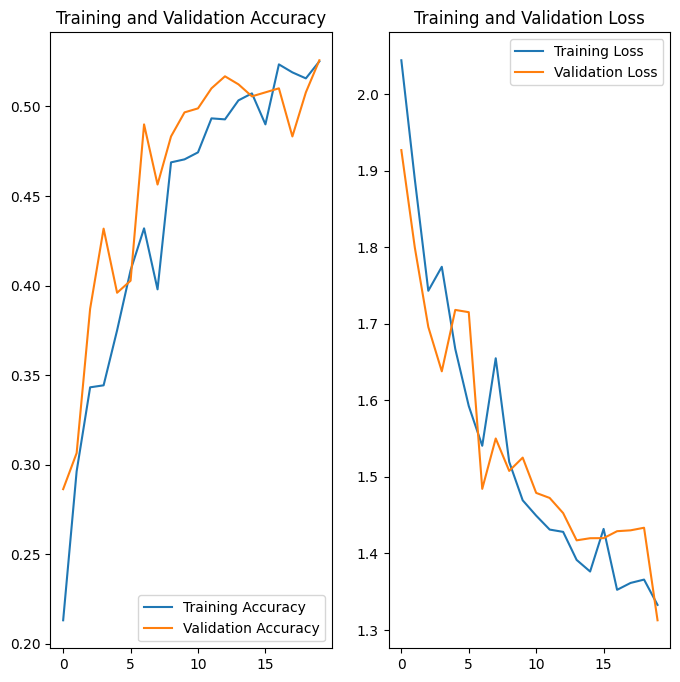

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The reduction in overfitting is evident as the loss function results for the validation and training sets exhibit similar trends and yield comparable outcomes. Moreover, the training accuracy plateauing is mirrored by the validation accuracy.

- Upon running the model without augmentation but with dropouts previously, it becomes apparent that dropouts primarily contribute to mitigating overfitting throughout most epochs. However, in the absence of augmentation, as the model continues to learn over more epochs, the validation loss and accuracy reach a plateau while the training loss continues to decrease and the training accuracy improves. This suggests that the model tends to memorize the training set without augmentation, with dropouts merely delaying this phenomenon.

- To enhance learning, it may be beneficial to rebalance the dataset and/or employ additional augmentation techniques.

#### Class Distribution

In [43]:
#find class distribution. If it's not balanced, we will try to balance it
def calculate_class_distributions(directory):
    subdirectories = list(pathlib.Path(directory).glob('*'))  # List of all subdirectories in the specified directory

    counts = [len(list(subdir.glob('*'))) for subdir in subdirectories]  # Count the number of images in each subdirectory
    class_names = [subdir.name for subdir in subdirectories]  # Names of each subdirectory (class names)

    class_distribution_df = pd.DataFrame({'Class': class_names, 'Image Count': counts})  # DataFrame of classes and image counts

    return class_distribution_df

class_distributions = calculate_class_distributions(data_dir_train)

class_distributions



,Class,Image Count
0,.DS_Store,0
1,nevus,357
2,pigmented benign keratosis,462
3,basal cell carcinoma,376
4,melanoma,438
5,dermatofibroma,95
6,actinic keratosis,114
7,seborrheic keratosis,77
8,squamous cell carcinoma,181
9,vascular lesion,139


###### It is evident that there are significant class imbalances within the dataset. The class "melanoma" stands out with a substantial number of 438 sample images, while "seborrheic keratosis" has the fewest samples, totaling only 77.

###### These class imbalances pose notable challenges for the learning process, particularly in cases where certain conditions may appear visually similar to the human eye. Identifying the distinct patterns that differentiate these illnesses from one another becomes more difficult for the model due to the limited number of samples. As a result, the original issues with overfitting arise, as the model attempts to compensate for the lack of representative samples by excessively learning from the training set.

###### Addressing these class imbalances becomes crucial to improve the learning process. By rebalancing the dataset or implementing appropriate data augmentation techniques, we can provide the model with a more balanced representation of each class. This would enable the model to better generalize and capture the distinguishing characteristics of each illness, leading to improved performance and reduced overfitting.


#### Let's try to balance the classes
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [44]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [48]:
path_to_training_dataset = str(data_dir_train) + "/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FFA98D3B370>: 100%|██████████| 500/500 [00:27<00:00, 17.92 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFAA05389D0>: 100%|██████████| 500/500 [00:27<00:00, 18.18 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFA98D92FE0>: 100%|██████████| 500/500 [00:24<00:00, 20.78 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7FFA98D93A30>: 100%|██████████| 500/500 [01:54<00:00,  4.38 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FFB1028DFF0>: 100%|██████████| 500/500 [01:59<00:00,  4.20 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FFA98ED39A0>: 100%|██████████| 500/500 [00:26<00:00, 18.80 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FFA986760E0>: 100%|██████████| 500/500 [00:58<00:00,  8.54 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFA96EBA770>: 100%|██████████| 500/500 [00:23<00:00, 20.92 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FFA98D390C0>: 100%|██████████| 500/500 [00:26<00:00, 18.92 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [49]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [51]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/nevus/output/nevus_original_ISIC_0000498.jpg_9b4b6601-8dab-4982-b975-b282820a1fba.jpg',
 '/content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/nevus/output/nevus_original_ISIC_0028558.jpg_b429bed8-aeb4-4208-bb96-4ec96070c7ca.jpg',
 '/content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/nevus/output/nevus_original_ISIC_0000354.jpg_bd26a0bc-1b25-40ab-bd55-252ff70fd72a.jpg',
 '/content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/nevus/output/nevus_original_ISIC_0026626.jpg_bc849ab2-12bf-4c08-b41b-788499b37106.jpg',
 '/content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/nevus/output/nevus_original_ISIC_0010889.jpg_d741b63c-928c-4c91-a08e-f3ce998be196.jpg',
 '/content/gdrive/MyDrive/Melanoma_detection_assignment/Skin_cancer_dataset/Train/nevus/output/nevus_original_ISIC_0000509.jpg_e5d8e820-ab1b-4028-b120

In [52]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [55]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [58]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [59]:
df2['Label'].value_counts()

nevus                         500
pigmented benign keratosis    500
basal cell carcinoma          500
melanoma                      500
dermatofibroma                500
actinic keratosis             500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [60]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [69]:
#print(data_dir_train)
#data_dir_train= data_dir_train + "/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [71]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model 3( includes normalization & class balanced data)

In [76]:
input_shape = (180,180,3)
## model3
model3 = Sequential(name="model3")

##input layer
model3.add(layers.InputLayer(input_shape=input_shape))
model3.add(augmentation_pipeline)
model3.add(rescaling_pipeline)
##l1
model3.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.BatchNormalization())
##l2
model3.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.BatchNormalization())
##l3
model3.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.BatchNormalization())
##l4
model3.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.BatchNormalization())
##l5
model3.add(layers.Conv2D(512, kernel_size=(3,3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(0.5))
##l6
model3.add(layers.Flatten())
#output layer
model3.add(layers.Dense(len(class_names), activation='softmax'))

model2 = Sequential(name="model_2")
input_shape = (180,180,3)
##input layer
model2.add(layers.InputLayer(input_shape=input_shape))
model2.add(augmentation_pipeline)
model2.add(rescaling_pipeline)



#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [78]:
## selection of optimizer and loss function
from tensorflow.keras.optimizers import Adam
adam = Adam(amsgrad=True)

model3.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# View the summary of all layers
input_shape = (None,180,180,3)
model3.build(input_shape)
model3.summary()

Model: "model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 89, 89, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 87, 87, 64)        18496

#### **Todo:**  Train your model

In [79]:
##50 epochs
epochs = 50

history = model3.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 52s 269ms/step - loss: 2.4052 - accuracy: 0.3435 - val_loss: 2.7573 - val_accuracy: 0.1455
Epoch 2/50
169/169 [==============================] - 45s 257ms/step - loss: 2.0062 - accuracy: 0.3726 - val_loss: 2.7980 - val_accuracy: 0.1826
Epoch 3/50
169/169 [==============================] - 44s 254ms/step - loss: 1.9441 - accuracy: 0.3986 - val_loss: 3.3126 - val_accuracy: 0.1054
Epoch 4/50
169/169 [==============================] - 44s 252ms/step - loss: 1.7457 - accuracy: 0.4277 - val_loss: 20.3892 - val_accuracy: 0.1611
Epoch 5/50
169/169 [==============================] - 45s 261ms/step - loss: 1.7777 - accuracy: 0.4399 - val_loss: 2.7125 - val_accuracy: 0.3170
Epoch 6/50
169/169 [==============================] - 47s 269ms/step - loss: 1.7106 - accuracy: 0.4490 - val_loss: 3.1310 - val_accuracy: 0.2569
Epoch 7/50
169/169 [==============================] - 44s 251ms/step - loss: 1.5500 - accuracy: 0.4722 - val_loss: 2.4767 - val_a

#### **Todo:**  Visualize the model results

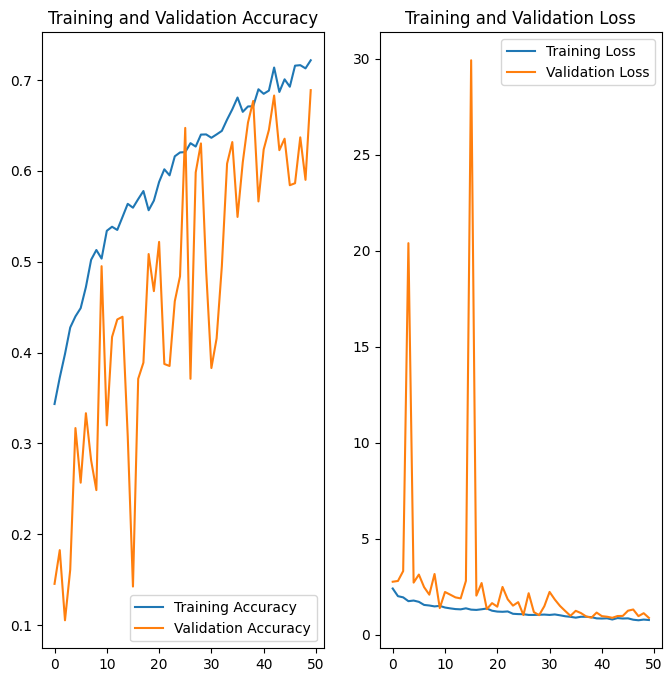

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Results



## Conclusion
#### We came up with 3 Models

| Models | Train Accuracy | Test Accuracy | Epochs |
| --- | --- | --- |--- |
|  Model1(Base Architecture Model) | 70.1 | 51.6 | 20 |
|  Model2(Data Augmentation/Dropouts|  52.5|  52.5 | 20 |
|  Model3(Class rebalance/Batch Norm)|  72  |  69  | 50 |




- Model1(Base model) behaved poorly and overfitted on the Validation set. This indicated that the model was simply memorizing the training set and failing to recognize any genuine patterns.

- Model2(Data Augmentation/Dropouts)Data Augmentation and dropouts helped big time to overcome the issue of overfitting. Thought accuracy was low model learnt and behaved consistently on the Validation sets

- Model3(Class rebalance/Batch Norm) - Class rebalance and Batch norm helped further increased the accuracy to 72% on the training set and 69% on Vaidation set which showed a lot of improvements from Model2. However, we observed the accuracy being oscilating during 50 epochs on validation set. This was happening probably due Batch normaliation using smaller batch size.

## Recommendations

#### To increase the accuracy following can be tried:-
- Increase the batch size for batch  normalization . This will certainly reduce the noise.
- Try Group normaliation to make model stable
- Adjust the momentum of Batch Normaliation